# Section 1: Business understanding

We want to find out how you can save on trip to Boston? Maybee to go off season, or to live farther from Boston city center.

Key questions we wanted to answer:
1. When is high season to travel to Boston?
2. Is there is a significant price change for accommodation?
3. All the cities raise prices in high season, if yes than by what percent?
4. Is there any connections between price, distance from the city center and satisfaction with the stay?

In [109]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from math import radians, sin, cos, sqrt

# Section 2: Data Understanding


## Gather 


In [94]:
#reading all the dataframes from the directory
df = pd.read_csv('/Users/reznichenkoanastasia/Downloads/archive (1)/listings.csv')
df_cal = pd.read_csv('/Users/reznichenkoanastasia/Downloads/archive (1)/calendar.csv')
df_rev = pd.read_csv('/Users/reznichenkoanastasia/Downloads/archive (1)/reviews.csv')


## Assess data

In [95]:
df_rev

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...
...,...,...,...,...,...,...
68270,7462268,80537457,2016-06-18,22034145,Antonio,Joe y su mujer son encantadores. La habitación...
68271,7462268,83640094,2016-07-03,40052513,Steve,Joe was on his way to Jamaica to be married! o...
68272,7462268,85797088,2016-07-13,77129134,Nick,The room was very clean as were the bathrooms ...
68273,7462268,97264637,2016-08-26,15799803,Vid,Staying in Lower Allston at Joe and Nancy's pl...


## Clean

We are going to work with columns price, listing_id, date from dataframe df_cal, and with price, latitude, longitude, review_scores_value from dataframe df. Before we start lets clean the data from nan values and we want to remove outliars and unrealistic values
-For Date column I decided to remove nan, because you we have enough data to analyze and just to fill with mean values will be not accurate.
-For Price column in both dataframes I decided to remove all nan prices because we still have enough data to work with, and predict the price based on the information we have is impossible.
-Price column have some unrealistic price changes. Like the price from $75 raised to $750. And it was only for one day, so it looks like a typo. I used quantile thresholding method to remove outliars and unrealistic price changes
-Price column is an object,and it has "$" and "," in it.So first we would replace that and convert it to numerical


In [96]:
# We removing na values ,converting column from object to numerical so we would be able to work with them in future


def convert_to_num(data):
    '''
    
    Convert the 'price' column in a DataFrame to numeric format.

    Parameters:
        data (pandas.DataFrame): Input DataFrame.

    Returns:
        pandas.DataFrame: DataFrame with a new column 'normal_price' containing the converted numeric prices.
    '''
    
    df1 = data.copy()
    df1.dropna(subset=['price'])
    df1['normal_price'] = df1['price'].str.replace('$', '').str.replace(',', '')
    df1['normal_price'] = pd.to_numeric( df1['normal_price'])
    return  df1

df = convert_to_num(df)
df_cal = convert_to_num(df_cal)

# removing non date
df_cal.dropna(subset=['date'], inplace=True)



# creating the table that is a copy of df_cal, using quantile thresholding method to remove outliars and unrealistic price 

temp = df_cal.copy()
qdf = temp.groupby('listing_id')['normal_price'].quantile([0.05,0.95])
temp.set_index('listing_id', inplace=True)
temp['q_0.05'] = qdf.loc[(slice(None), 0.05)]
temp['q_95'] = qdf.loc[(slice(None), 0.95)]
temp = temp[temp['normal_price']>temp['q_0.05']]
temp = temp[temp['normal_price']<temp['q_95']]

/var/folders/l3/35p0rvxn07nbl5w1stvlssmm0000gn/T/ipykernel_24268/1835150959.py:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df1['normal_price'] = df1['price'].str.replace('$', '').str.replace(',', '')
/var/folders/l3/35p0rvxn07nbl5w1stvlssmm0000gn/T/ipykernel_24268/1835150959.py:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df1['normal_price'] = df1['price'].str.replace('$', '').str.replace(',', '')


### Data preparation and feature engineering

In [97]:
# Extract month from date using library from datetime import datetime

df_cal['month']=df_cal['date']
df_cal['month']=pd.to_datetime(df_cal['month'],infer_datetime_format=True)
df_cal['month']=df_cal['month'].dt.month

Creating new column Distance that calculates the distance from the accommodation to Faneuil Hall Visitor Center (Boston city center). We would need it later, to see is there any connection between distance to the city center and satisfaction from your stay



In [98]:
def calc_distance(df):
    
    '''
    
    Creates new column "distance" in DataFrame df using longitute and latitute columns.

    Parameters:
        df (pandas.DataFrame): Input DataFrame.

    Returns:
        pandas.DataFrame: DataFrame with a new column ''distance_to_cent' containing the converted numeric distance.
    '''
    
    lat1 = radians(42.360031)
    lon1 = radians(-71.054749)

    lon2 = df['longitude'].apply(radians)
    lat2= df['latitude'].apply(radians)

    diff_lat = lat2 - lat1
    diff_lon = lon2 - lon1

    #the haversine formula
    df['distance_to_cent'] = 2*3959*np.arcsin(np.sqrt(np.sin(diff_lat/2)**2+\
                                                      np.cos(lat1)*np.cos(lat2)*np.sin(diff_lon/2)**2))
    return df

calc_distance(df)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,normal_price,distance_to_cent
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,NaN,f,moderate,f,f,1,NaN,250.0,6.679962
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,NaN,NaN,t,moderate,f,f,1,1.30,65.0,6.522621
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,NaN,NaN,f,moderate,t,f,1,0.47,65.0,6.240433
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,NaN,NaN,f,moderate,f,f,1,1.00,75.0,6.419094
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,NaN,NaN,f,flexible,f,f,1,2.25,79.0,6.676054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3580,8373729,https://www.airbnb.com/rooms/8373729,20160906204935,2016-09-07,Big cozy room near T,5 min walking to Orange Line subway with 2 sto...,NaN,5 min walking to Orange Line subway with 2 sto...,none,NaN,...,NaN,NaN,t,strict,f,f,8,0.34,69.0,2.071593
3581,14844274,https://www.airbnb.com/rooms/14844274,20160906204935,2016-09-07,BU Apartment DexterPark Bright room,"Most popular apartment in BU, best located in ...",Best location in BU,"Most popular apartment in BU, best located in ...",none,NaN,...,NaN,NaN,f,strict,f,f,2,NaN,150.0,3.360330
3582,14585486,https://www.airbnb.com/rooms/14585486,20160906204935,2016-09-07,Gorgeous funky apartment,Funky little apartment close to public transpo...,Modern and relaxed space with many facilities ...,Funky little apartment close to public transpo...,none,"Cambridge is a short walk into Boston, and set...",...,NaN,NaN,f,flexible,f,f,1,NaN,198.0,1.171354
3583,14603878,https://www.airbnb.com/rooms/14603878,20160906204935,2016-09-07,Great Location; Train and Restaurants,"My place is close to Taco Loco Mexican Grill, ...",NaN,"My place is close to Taco Loco Mexican Grill, ...",none,NaN,...,NaN,NaN,f,strict,f,f,1,2.00,65.0,2.194547


# Section 3:  Evaluate the results


### 1. When is high season to travel to Boston?
When you travel to a city you might have preferences like how to avoid crowds or how to save some money on a hotel. Of course, during high season we would have tourists flooding the streets and prices of accommodation go up as well. To answer the question of what season is high we need to check price changes during the year. During the high season, prices are always higher while the low season gives us a better price.

We would use our dataframe df_cal and will use boxplot to see price distribution by month.

In [99]:
#inline will show us boxplot in notebook
%matplotlib inline

<AxesSubplot:xlabel='month', ylabel='normal_price'>

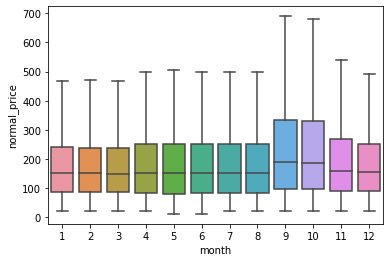

In [100]:
#using boxplot to visualize distribution between prices
sns.boxplot(x='month',y='normal_price',data=df_cal,showfliers=False)

#### We can definitely conclude that most expensive months are September and October.It is the highest season.But it's difficult to say what is low season 

To find lower season and to have better picture at all we would find the average price by month and use plot line to visializate it.

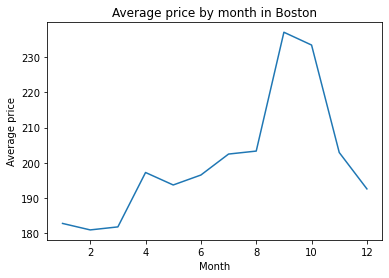

In [101]:
#using plot to visualize the mean price per month

plt.plot(df_cal.groupby('month').mean('normal_price')[['normal_price']])
plt.xlabel('Month')
plt.ylabel('Average price')
plt.title('Average price by month in Boston')
plt.show()

#### We can clearly see that starting from the August prices are starting to go up and in December they are going down.The lowest prices are in February.This means that if you whant to avoid crowds of people and high prices, you shouldn't peak this  and you are not afraid of New Englad's winter you need to pick December for your trip.You can save a lot on your trip.

### 2. Is there is a significant price change for accommodation?


To understand is it really that much change in price, or it is not significant at all and makes it worthless to worry about? To answer that question we would find the highest price and lowest price for the same property using listing_id. We will plot both lines on the plot to see if they coincide or not. And if they don't coincide, is there a big difference between them? Blue response for the highest prices for property and blue for the lowest.
 



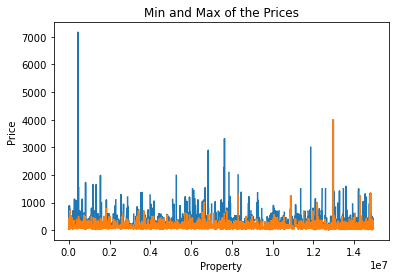

In [102]:
#using plot to visualize maximum prices and minimum prices for the same listing_id

plt.plot(df_cal.groupby('listing_id').max('normal_price')['normal_price'])
plt.plot(df_cal.groupby('listing_id').min('normal_price')['normal_price'])
plt.xlabel('Property')
plt.ylabel('Price')
plt.title('Min and Max of the Prices')
plt.show()

 We can see that some properties really raised the prices significally.

###  3. All the cities raise prices in high season and by what percent?


We want to find out if in all the cities the price varies depending on the season, and by what percent it varies. It helps to understand if you we can still save some money if we want to go in high season. Maybe some cities raise their prices much less than others.

We are finding the highest and lowest price for the same property in the same city.Using mathematical formula we find by what percent prices have changed.

In [105]:
#To table that we created before add column from dataframe df
temp['city'] = df['city']
temp.reset_index(inplace=True)
#finding max and min for every listing in every city
grouped_prices = temp.groupby(['listing_id','city'])['normal_price'].agg(['max', 'min'])
#finding percent changed
grouped_prices['percent']=(grouped_prices['max']-grouped_prices['min'])/grouped_prices['min']*100
tt=grouped_prices.groupby('city').mean(['percent'])['percent']
tt.sort_values()


city
ALLSTON                       0.000000
dorchester, boston            0.000000
boston                        0.000000
Watertown                     0.000000
South End, Boston             0.000000
South Boston                  0.000000
Roslindale, Boston            0.000000
Newton                        0.000000
Mission Hill, Boston          0.000000
Milton                        0.000000
Mattapan                      0.000000
Jamaica plain                 0.000000
Jamaica Plain, MA             0.000000
east Boston                   0.000000
Jamaica Plain (Boston)        0.000000
Jamaica Plain                 0.000000
Jamaica Plain, Boston         0.000000
Hyde Park                     0.000000
Boston                        0.000000
Boston (Charlestown)          0.000000
Boston (Jamaica Plain)        0.000000
Brighton                      0.000000
Boston, Massachusetts, US     0.000000
Charlestown                   0.000000
East Boston                   0.000000
波士顿                 

We already see that some cities are not raising their price at all. But for better understanding, we would visualize it on a plot. It's a very detailed plot, so we use %matplotlib qt instruction to make it interactive

In [106]:
# Please note that chart will open in new window
%matplotlib qt

plt.bar(tt.index,tt)
plt.xticks(rotation=45)
plt.show()


/Users/reznichenkoanastasia/opt/anaconda3/lib/python3.9/site-packages/ipykernel/eventloops.py:105: UserWarning: Glyph 27874 (\N{CJK UNIFIED IDEOGRAPH-6CE2}) missing from current font.
  app.exec_()
/Users/reznichenkoanastasia/opt/anaconda3/lib/python3.9/site-packages/ipykernel/eventloops.py:105: UserWarning: Glyph 22763 (\N{CJK UNIFIED IDEOGRAPH-58EB}) missing from current font.
  app.exec_()
/Users/reznichenkoanastasia/opt/anaconda3/lib/python3.9/site-packages/ipykernel/eventloops.py:105: UserWarning: Glyph 39039 (\N{CJK UNIFIED IDEOGRAPH-987F}) missing from current font.
  app.exec_()


#### We can see that some cities don't raise the prices for accommodation at all.We can save money staying there.

### 4. Is there any connections between price, distance from the city center and satisfaction with the stay?

We can assume that if you pay more you get more or that living closer to city center makes your stay better. But do we really have any connection between satisfaction from the stay and price of the accommodation or distance to city center?

To check that we would find correlation between columns review rating, price and distance (the column we created earlier).

In [107]:
#finding correlation between values
df[['review_scores_rating','distance_to_cent', 'normal_price']].corr()
    

,review_scores_rating,distance_to_cent,normal_price
review_scores_rating,1.000000,-0.022225,0.105651
distance_to_cent,-0.022225,1.000000,-0.295621
normal_price,0.105651,-0.295621,1.000000


Based on numbers we there is no strong correlation between this columns.

<AxesSubplot:>

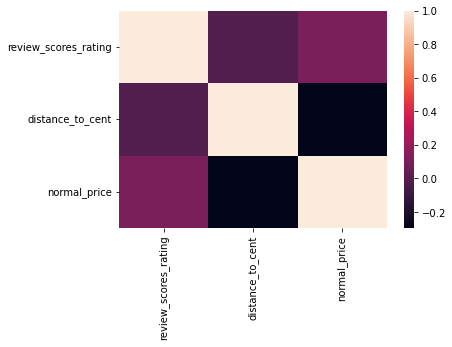

In [108]:
# And heatmap to vizualizate correlation
%matplotlib inline

sns.heatmap(df[['review_scores_rating','distance_to_cent', 'normal_price']].corr())

#### We can see that the price of the place you stay or how close it is to the city center doesn't make a real impact on the satisfaction of your stay.